In [1]:
%load_ext lab_black
%load_ext watermark
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic
from scipy.special import softmax

warnings.simplefilter(action="ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]

In [3]:
data_simulated = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    ]
)

In [28]:
# Number of customers
N = 3000
preference_lat = np.array(
    [0.25, 0.125, 0.125, 0.10, 0.10, 0.10, 0.10, 0.05, 0.025, 0.025]
)
p_slots_avail = np.array([0.1, 0.1, 0.1, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 1])
slots_available = sp.stats.bernoulli.rvs(p_slots_avail, size=(N, 10))
slots_available

array([[1, 0, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 0, 1]])

In [29]:
# Number of available choices per customer
no_slots = slots_available.sum(axis=1)

In [6]:
a = -2
b = 0.8
p_conv = sp.stats.logistic.cdf(a + b * no_slots)
p_conv

array([0.76852478, 0.94267582, 0.76852478, ..., 0.94267582, 0.97340301,
       0.59868766])

In [36]:
(slots_available * preference_lat).sum(axis=1).shape

(3000,)

In [7]:
# Keep only preferences for available choices
slot_prob = slots_available * preference_lat

# Normalize preferences to probability of choice 1 to 10 given that customer orders
slot_prob_normalized = (
    slot_prob / (slots_available * preference_lat).sum(axis=1)[..., np.newaxis]
)

# Add the probability of not ordering (logistic output) and renormalize such that
# all probabilities sum to 1
slot_prob_norm2 = p_conv[..., np.newaxis] * slot_prob_normalized
data_prob = np.concatenate((slot_prob_norm2, 1 - p_conv[..., np.newaxis]), axis=1)
data_prob

array([[0.        , 0.        , 0.        , ..., 0.        , 0.06986589,
        0.23147522],
       [0.        , 0.        , 0.24807259, ..., 0.04961452, 0.04961452,
        0.05732418],
       [0.        , 0.        , 0.        , ..., 0.07685248, 0.07685248,
        0.23147522],
       ...,
       [0.        , 0.        , 0.        , ..., 0.05891724, 0.05891724,
        0.05732418],
       [0.37438577, 0.        , 0.        , ..., 0.03743858, 0.03743858,
        0.02659699],
       [0.        , 0.        , 0.        , ..., 0.        , 0.06652085,
        0.40131234]])

In [8]:
# Draw from choice space. Each customer (row) faces has a different
# choice distribution as the available choices differ between each customer
# (according to p_slots_avail)
def mnomial(slc):
    return np.random.multinomial(1, slc)


data_simulated = np.apply_along_axis(mnomial, 1, data_prob)
data_simulated

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [25]:
with pm.Model() as model:
    # This part works as intended, the posteriors are around the true values of the 
    # choice availability distributions
    p_slots_avail_ = pm.Uniform('p_slots_avail_', shape=10, lower=0., upper=1.)
    slots_available_ = pm.Bernoulli('slots_available_', p=p_slots_avail, shape=10, 
                                       observed=slots_available)
    
    # This logistic regression part works as intended, the posteriors of pm_a and pm_b are 
    # around the true values of a and b
    nbr_slots = pm.Deterministic('nbr_slots', slots_available_.sum(axis=1))
    a = pm.Uniform('a', lower=-10, upper=10)
    b = pm.Uniform('b', lower=-10, upper=10)
    p_conv_ = pm.Deterministic('p_conv_', pm.math.sigmoid(a + b*nbr_slots))
    order = pm.Bernoulli('order', 
                            p=p_conv_,
                            observed=1-data_simulated[:, 10])
    
    # This part does not work / sampling for pm_choice is extremely slow
    preference_lat_ = pm.Dirichlet('preference_lat_', a=np.ones(10), shape=10)
    slot_prob_ = slots_available_ * preference_lat_
    slot_prob_normalized_ = slot_prob_ / (slots_available_*preference_lat_).sum(axis=1)[..., np.newaxis] 
    slot_prob_norm2_ = p_conv_[..., np.newaxis] * slot_prob_normalized_
    data_prob_ = tt.concatenate((slot_prob_norm2_, 1 - p_conv_[..., np.newaxis]), axis=1)
    choice = pm.Categorical('choice', 
                               p=data_prob_,
                               observed=data_simulated)
    
    trace_itc_fix = pm.sample(
        1000, tune=2000, cores=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (3000,11) (1,3000) 

In [2]:
d = pd.read_excel("data/results_by_arrdmt.xlsx", index_col=0)
# to simulate mltn data
obs_pref = d[PARTIES].divide(d["N"], axis=0).mean().values[:-1]
# A party that wasn't there won 0 ballots:
d[PARTIES] = d[PARTIES].fillna(0).astype(int)
d

,date,ville,arrondissement,N,farleft,left,green,center,right,farright,other,type
0,2008-05-23,Paris,1,6127,75,2289,439,531,2641,152,0,municipale
1,2014-03-25,Paris,1,6079,154,1663,659,0,3144,306,153,municipale
2,2017-04-23,Paris,1,9026,1231,659,0,3561,2831,443,301,president
3,2017-06-11,Paris,1,6282,434,418,363,2958,1525,148,436,legislative
4,2008-05-23,Paris,2,6736,90,2231,2016,621,1543,167,68,municipale
...,...,...,...,...,...,...,...,...,...,...,...,...
75,2017-06-11,Paris,19,50024,9798,4488,5463,18429,3790,2129,5927,legislative
76,2008-05-23,Paris,20,56285,4776,21568,5329,4114,4076,2033,14389,municipale
77,2014-03-25,Paris,20,54966,5692,20502,5990,0,11467,4112,7203,municipale
78,2017-04-23,Paris,20,89574,28512,12469,0,27399,11451,5305,4438,president


What's the proportion of zeros in the respective categories?

In [12]:
1 - d[PARTIES].astype(bool).mean(axis=0).round(2)

farleft     0.05
left        0.00
green       0.25
center      0.25
right       0.00
farright    0.00
other       0.08
dtype: float64

Note that zeros in the category "other" are real multinomial zeros, while zeros in farleft, green and center result from the absence of these categories in the multinomial - they were eliminated upstream from the multinomial trials and are therefore not real multinomial zeros. Also note that the zero-inflated categories are not jointly-inflated (green is not necessaricly 0 when center is, and vice-versa).

Now let's look at each category's distribution (we zoom-in to really see zero-inflations):

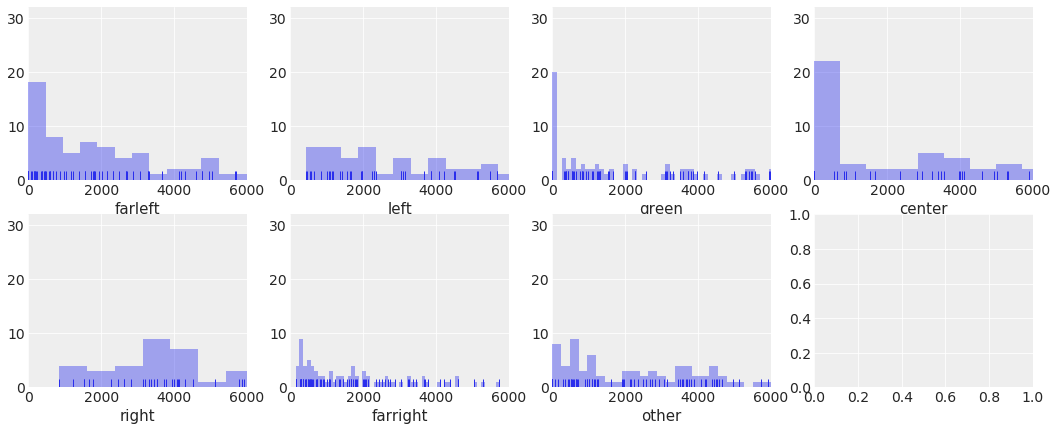

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(18, 7))
i = 0
for line in axes:
    for col in line:
        try:
            sns.distplot(d[PARTIES[i]], bins=60, kde=False, rug=True, ax=col)
            col.set_xlim([0, 6_000])
            col.set_ylim([0, 32])
            i += 1
        except IndexError:
            continue

That's not the best plot, but we can see that farleft, green and center do have a tendency to zero-inflation. Now, how can we model this mixed process?

First, let's run a plain multinomial regression, starting by defining index variables:

In [4]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)
Nparties = len(PARTIES)
N = d.N.values
R_obs = d[PARTIES].values
slots_available = pd.concat(
    [
        d[PARTIES].astype(bool).astype(int).iloc[:, :-1],
        pd.Series([1] * len(d), name="other"),
    ],
    axis=1,
).values

In [5]:
# Try Poison parametrization

true_a = pm.Normal.dist(-1.8, 0.1, shape=Nparties - 1).random()
print("true_a: ", true_a)
true_sigma_district = pm.Exponential.dist(1.0).random()
print("true_sigma_district: ", true_sigma_district)

true_a_district = pm.Normal.dist(
    true_a, true_sigma_district, shape=(Ndistricts, Nparties - 1)
).random()
true_a_district_f = np.hstack((true_a_district, np.zeros(shape=(Ndistricts, 1))))

# preferences of each district:
true_p_district = softmax(true_a_district_f)
print("true_p_district: ", true_p_district.shape)
# preferences of each district, for 4 elections:
true_lat_p = true_p_district[district_id]

# Keep only preferences for available parties:
true_slot_prob = slots_available * true_lat_p
# Normalize preferences:
true_slot_prob = true_slot_prob / np.sum(true_slot_prob, axis=1, keepdims=True)

sim_R = pm.Multinomial.dist(n=N, p=true_slot_prob).random()
print("sim_R: ", sim_R.shape)

true_a:  [-1.84143726 -1.85520318 -1.9692786  -1.87347931 -1.8280312  -1.69802554]
true_sigma_district:  0.17838526561891468
true_p_district:  (20, 7)
sim_R:  (80, 7)


In [42]:
with pm.Model() as m_multi:
    a = pm.Normal("a", -1.8, 0.1, shape=Nparties - 1)
    sigma_district = pm.Exponential("sigma_district", 1.0)

    a_district = pm.Normal(
        "a_district", a, sigma_district, shape=(Ndistricts, Nparties - 1)
    )
    a_district_f = tt.horizontal_stack(a_district, tt.zeros(shape=(Ndistricts, 1)))

    p_district = pm.Deterministic("p_district", tt.nnet.softmax(a_district_f))
    lat_p = tt.nnet.softmax(a_district_f[district_id])

    # Keep only preferences for available choices:
    slot_prob = slots_available * lat_p
    # Normalize preferences for available choices:
    slot_prob = slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=sim_R)

    trace_multi = pm.sample(
        2000, tune=3000, cores=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

az.summary(trace_multi, round_to=2, var_names=["a", "sigma_district", "p_district"])

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_district, sigma_district, a]
INFO:pymc3:NUTS: [a_district, sigma_district, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [01:16<00:00, 131.06draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.80,0.04,-1.88,-1.73,0.0,0.0,6104.81,6085.45,6097.18,2870.00,1.0
a[1],-1.83,0.04,-1.91,-1.76,0.0,0.0,6016.27,6010.64,6023.65,3047.78,1.0
a[2],-1.92,0.04,-2.00,-1.85,0.0,0.0,7077.27,7065.37,7069.66,2760.65,1.0
a[3],-1.86,0.04,-1.94,-1.78,0.0,0.0,4618.27,4618.27,4609.59,3059.14,1.0
a[4],-1.81,0.04,-1.89,-1.74,0.0,0.0,4778.95,4778.95,4767.87,2683.45,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"p_district[19,2]",0.09,0.00,0.09,0.09,0.0,0.0,6141.53,6134.64,6138.41,3010.33,1.0
"p_district[19,3]",0.09,0.00,0.09,0.09,0.0,0.0,5284.06,5283.25,5260.01,3080.92,1.0
"p_district[19,4]",0.07,0.00,0.07,0.07,0.0,0.0,5796.99,5790.00,5756.52,3072.24,1.0
"p_district[19,5]",0.08,0.00,0.08,0.08,0.0,0.0,5937.20,5935.25,5929.52,3077.30,1.0


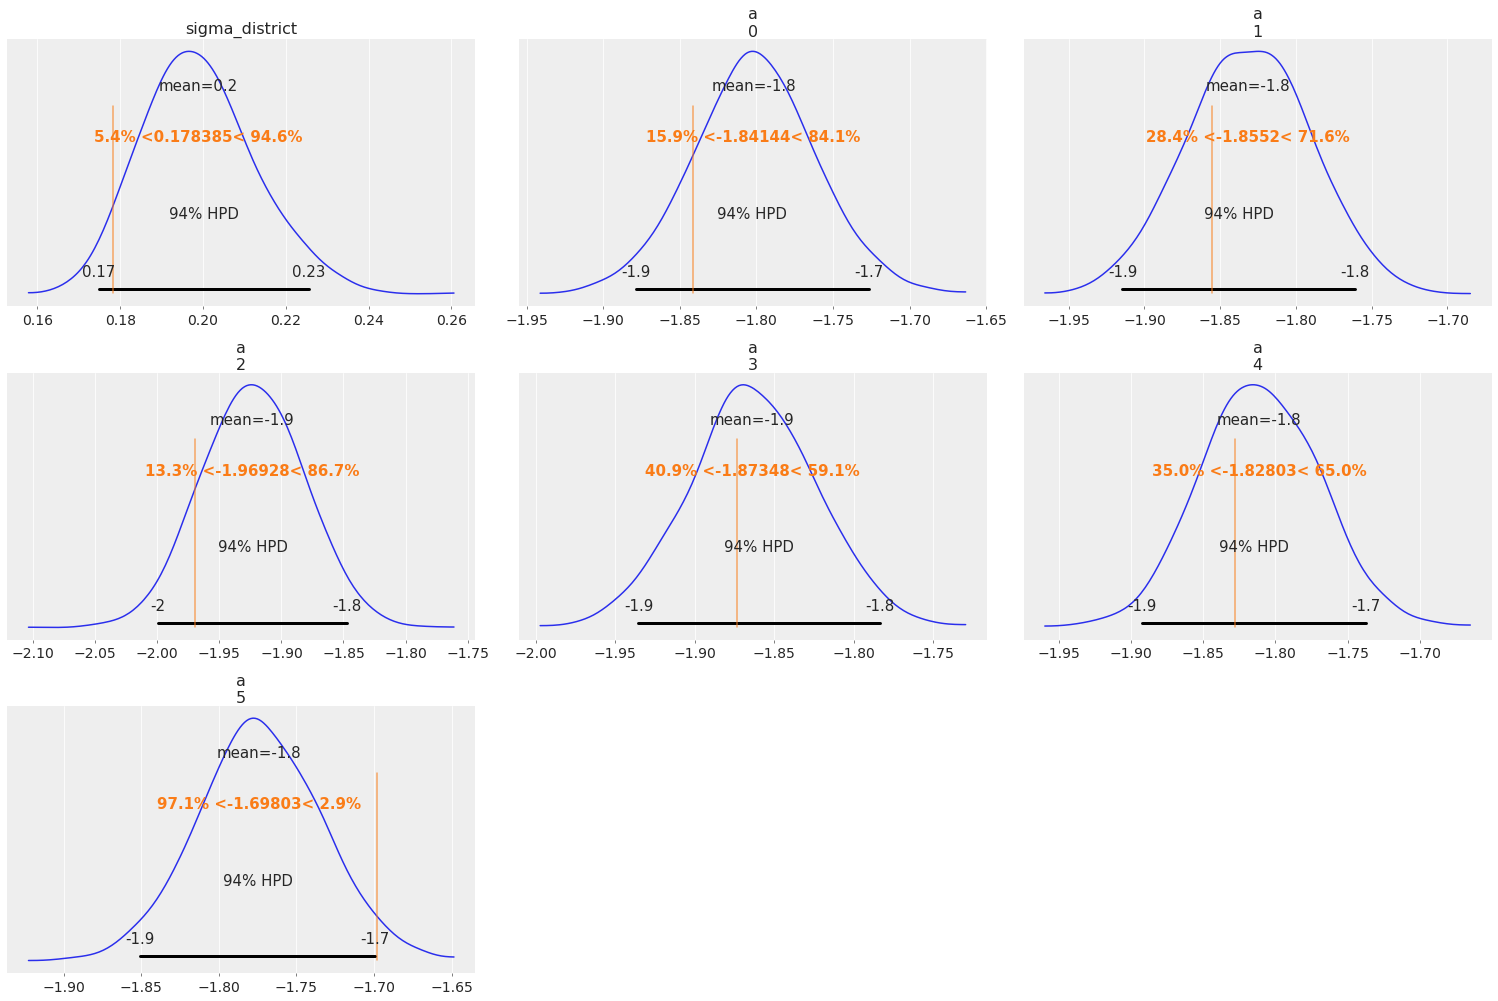

In [43]:
a_vals = [{"a_dim_0": i, "ref_val": true_a[i]} for i in range(len(true_a))]
s_vals = [{"ref_val": true_sigma_district}]
az.plot_posterior(
    trace_multi,
    var_names=["sigma_district", "a"],
    ref_val={"sigma_district": s_vals, "a": a_vals},
)

# lines = [("a", {"a_dim_0": i}, true_a[i]) for i in range(len(true_a))]
# az.plot_trace(
# trace_multi,
#  var_names=["sigma_district", "a"],
#   lines=[("sigma_district", {}, true_sigma_district)] + lines,
# )

In [88]:
az.summary(trace_multi, round_to=2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lat_pref[0],0.10,0.0,0.10,0.10,0.0,0.0,3105.23,3105.23,3088.16,1502.14,1.0
lat_pref[1],0.20,0.0,0.20,0.20,0.0,0.0,2685.96,2685.53,2684.89,1601.88,1.0
lat_pref[2],0.07,0.0,0.07,0.07,0.0,0.0,2528.91,2528.91,2534.23,1484.33,1.0
lat_pref[3],0.28,0.0,0.28,0.28,0.0,0.0,2872.10,2871.16,2867.60,1745.02,1.0
lat_pref[4],0.24,0.0,0.24,0.24,0.0,0.0,3297.62,3297.57,3295.61,1769.66,1.0
lat_pref[5],0.04,0.0,0.04,0.04,0.0,0.0,3071.81,3071.81,3062.37,1829.20,1.0
lat_pref[6],0.07,0.0,0.07,0.07,0.0,0.0,3159.25,3159.25,3159.59,1894.52,1.0


In [1]:
# https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/multivariate.py
# https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/discrete.py

# https://discourse.pymc.io/t/the-zero-inflated-exponential/2538
# https://discourse.pymc.io/t/literature-on-implementing-a-zero-inflated-beta-likelihood/2503
# https://discourse.pymc.io/t/zero-inflated-poisson-log-lik/2664
# https://discourse.pymc.io/t/sampling-from-a-learned-mixture-of-zeros-and-lognormal/3671/2

# https://www.birs.ca/workshops/2019/19w5128/files/slides_ZIGDM.pdf
# https://rdrr.io/cran/miLineage/man/ZIGDM.html